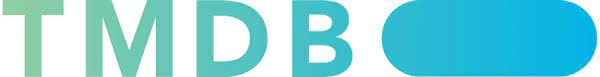

# TMDb Movie Data Analysis and Building a Movie Recommendation System
* # Part 1: Data Cleaning/Transformation
### In this project, we will analyze movie data from the TMDB database, and try to extract some meaningful insight from it with Exploratory Data Analysis, visualization, and DataFrame manipulations. 
### There are four parts to this end-to-end project:
### • Data download, data cleaning, feature engineering.
### • Exploratory Data Analysis.
### • Creating the final dataset and creating the recommendation algorithm.
### • Creating a Streamlit app to be deployed on Heroku.
### The first part of this project will focus on cleaning and manipulating the DataFrame, extracting any valuable information and removing any data that is not needed.
### The end result will be a movie recommendation system based on movie vector similarity.

* **id:** The ID of the movie (clear/unique identifier).
* **title:** The Official Title of the movie.
* **tagline:** The tagline of the movie.
* **release_date:** Theatrical Release Date of the movie.
* **genres:** Genres associated with the movie.
* **belongs_to_collection:** Gives information on the movie series/franchise the particular film belongs to.
* **original_language:** The language in which the movie was originally shot in.
* **budget_musd:** The budget of the movie in million dollars.
* **revenue_musd:** The total revenue of the movie in million dollars.
* **production_companies:** Production companies involved with the making of the movie.
* **production_countries:** Countries where the movie was shot/produced in.
* **vote_count:** The number of votes by users, as counted by TMDB.
* **vote_average:** The average rating of the movie.
* **popularity:** The Popularity Score assigned by TMDB.
* **runtime:** The runtime of the movie in minutes.
* **overview:** A brief blurb of the movie.
* **spoken_languages:** Spoken languages in the film.
* **poster_path:** The URL of the poster image.
* **cast:** (Main) Actors appearing in the movie.
* **cast_size:** number of Actors appearing in the movie.
* **director:** Director of the movie.
* **crew_size:** Size of the film crew (incl. director, excl. actors).

## Loading the main libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import urllib
import requests
import json
import gzip
import time
from tqdm import tqdm

pd.options.display.max_columns = 20

## Getting all valid movie IDs from TMDB's Daily File Exports

In [3]:
def get_movie_ids():
    json_gz_path = 'http://files.tmdb.org/p/exports/movie_ids_10_28_2021.json.gz' # Path of compressed json file of movie ids.
    urllib.request.urlretrieve(json_gz_path,'movie_ids_10_28_2021.json.gz') # This will download the compressed json file which contains all movie ids.
    movie_ids = []
    with gzip.open('movie_ids_10_28_2021.json.gz', 'r') as f:
        for line in f:
            movie_ids.append(json.loads(line)['id'])
    return movie_ids

In [4]:
movie_ids = get_movie_ids()

In [5]:
print(f"First 10 movie ids: {movie_ids[:10]}")
print(f"# of movie ids: {format(len(movie_ids), ',d')}")

First 10 movie ids: [3924, 6124, 8773, 25449, 31975, 2, 3, 5, 6, 8]
# of movie ids: 650,449


## Downloading the movie dataset using TMDB's API

In [18]:
session = requests.Session()
session.headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.54 Safari/537.36",
    "Accept-Encoding": "*",
    "Connection": "keep-alive"
}

In [22]:
def retry(func, retries=10):
    def retry_wrapper(*args, **kwargs):
        attempts = 0
        while attempts < retries:
            try:
                return func(*args, **kwargs)
            except requests.exceptions.RequestException as e:
                print(e)
                time.sleep(5)
                attempts += 1
                
    return retry_wrapper

In [30]:
from api_key import api # Personal API key used to download the data.

failed_ids = []

@retry
def download_movie_data(movie_id, session=session):
    link = f'https://api.themoviedb.org/3/movie/{movie_id}?api_key={api}&language=en-US'
    response = session.get(link)
    if response.status_code == 200:
        return response.json()
    else:
        failed_ids.append(movie_id)
        return np.nan

In [ ]:
movies = []
pbar = tqdm(total=len(movie_ids))
for movie_id in movie_ids:
    movies.append(download_movie_data(movie_id))
    pbar.update(1)
pbar.close()

In [117]:
len(movies)

650643

In [118]:
len(failed_ids)

194

## Retrying failed movie requests

In [107]:
failed_movies = []
for failed_movie_id in failed_ids:
    failed_movies.append(download_movie_data(movie_id))

In [110]:
movies.extend(failed_movies)

In [111]:
len(movies)

650643

## Saving the resultant movies dataset

In [112]:
movies_series = pd.Series(movies).dropna()

In [113]:
df = pd.DataFrame.from_records(movies_series)

In [119]:
df.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,/dvQj1GBZAZirz1skEEZyWH2ZqQP.jpg,"{'id': 177062, 'name': 'Blondie Collection', '...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,3924,tt0029927,en,Blondie,...,1938-11-30,0,70.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Blondie,False,7.1,5
1,False,NaN,NaN,0,"[{'id': 12, 'name': 'Adventure'}]",NaN,6124,tt0011436,de,Der Mann ohne Namen,...,1921-01-01,0,420.0,[],Released,NaN,"Peter Voss, Thief of Millions",False,0.0,0
2,False,/uJlc4aNPF3Y8yAqahJTKBwgwPVW.jpg,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,8773,tt0055747,fr,L'amour à vingt ans,...,1962-06-22,0,110.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,The Intimate Secrets of Young Lovers,Love at Twenty,False,6.8,36
3,False,NaN,"{'id': 425256, 'name': 'New World Disorder', '...",0,[],http://www.nwdfilms.com,25449,NaN,en,New World Disorder 9: Never Enough,...,2008-12-08,0,69.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,New World Disorder 9: Never Enough,False,4.5,2
4,False,NaN,NaN,0,"[{'id': 10751, 'name': 'Family'}]",NaN,31975,tt1656746,en,Sesame Street: Elmo Loves You!,...,2010-01-05,0,46.0,[],Released,NaN,Sesame Street: Elmo Loves You!,True,0.0,0


In [115]:
df.to_csv('movies_metadata.csv', index=False)

# Downloading credits datasets for each movie

In [125]:
failed_ids = []

@retry
def download_credits_data(movie_id, session=session):
    link = f'https://api.themoviedb.org/3/movie/{movie_id}/credits?api_key={api}&language=en-US'
    response = session.get(link)
    if response.status_code == 200:
        return response.json()
    else:
        failed_ids.append(movie_id)
        return np.nan

In [126]:
credits = []
pbar = tqdm(total=len(movie_ids))
for movie_id in movie_ids:
    credits.append(download_credits_data(movie_id))
    pbar.update(1)
pbar.close()

100%|███████████████████████████████████████████████████████████████████████| 650449/650449 [12:30:37<00:00, 14.44it/s]


In [132]:
credits_series = pd.Series(credits).dropna()

In [133]:
credits_df = pd.DataFrame(credits_series)
credits_df.to_csv('credits.csv', index=False)
del credits_df

,0
0,"{'id': 3924, 'cast': [{'adult': False, 'gender..."
1,"{'id': 6124, 'cast': [{'adult': False, 'gender..."
2,"{'id': 8773, 'cast': [{'adult': False, 'gender..."
3,"{'id': 25449, 'cast': [{'adult': False, 'gende..."
4,"{'id': 31975, 'cast': [], 'crew': []}"
5,"{'id': 2, 'cast': [{'adult': False, 'gender': ..."
6,"{'id': 3, 'cast': [{'adult': False, 'gender': ..."
7,"{'id': 5, 'cast': [{'adult': False, 'gender': ..."
8,"{'id': 6, 'cast': [{'adult': False, 'gender': ..."
9,"{'id': 8, 'cast': [], 'crew': [{'adult': False..."


### • All of our data are downloaded and ready to view.

# Data Cleaning

## Some of the data attributes are in json format, so we will have to extract the columns/variables from json dictionary strings.

In [2]:
df = pd.read_csv('movies_metadata.csv', low_memory=False)
df

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,/dvQj1GBZAZirz1skEEZyWH2ZqQP.jpg,"{'id': 177062, 'name': 'Blondie Collection', '...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,3924,tt0029927,en,Blondie,...,1938-11-30,0,70.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Blondie,False,7.1,5
1,False,NaN,NaN,0,"[{'id': 12, 'name': 'Adventure'}]",NaN,6124,tt0011436,de,Der Mann ohne Namen,...,1921-01-01,0,420.0,[],Released,NaN,"Peter Voss, Thief of Millions",False,0.0,0
2,False,/uJlc4aNPF3Y8yAqahJTKBwgwPVW.jpg,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,8773,tt0055747,fr,L'amour à vingt ans,...,1962-06-22,0,110.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,The Intimate Secrets of Young Lovers,Love at Twenty,False,6.8,36
3,False,NaN,"{'id': 425256, 'name': 'New World Disorder', '...",0,[],http://www.nwdfilms.com,25449,NaN,en,New World Disorder 9: Never Enough,...,2008-12-08,0,69.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,New World Disorder 9: Never Enough,False,4.5,2
4,False,NaN,NaN,0,"[{'id': 10751, 'name': 'Family'}]",NaN,31975,tt1656746,en,Sesame Street: Elmo Loves You!,...,2010-01-05,0,46.0,[],Released,NaN,Sesame Street: Elmo Loves You!,True,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650444,False,NaN,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,890932,NaN,es,Palabra de fotógrafo - Testimonios sobre el 68,...,2011-01-01,0,57.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,NaN,Photographer's Words - 68 Testimonials,False,0.0,0
650445,False,NaN,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,890932,NaN,es,Palabra de fotógrafo - Testimonios sobre el 68,...,2011-01-01,0,57.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,NaN,Photographer's Words - 68 Testimonials,False,0.0,0
650446,False,NaN,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,890932,NaN,es,Palabra de fotógrafo - Testimonios sobre el 68,...,2011-01-01,0,57.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,NaN,Photographer's Words - 68 Testimonials,False,0.0,0
650447,False,NaN,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,890932,NaN,es,Palabra de fotógrafo - Testimonios sobre el 68,...,2011-01-01,0,57.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,NaN,Photographer's Words - 68 Testimonials,False,0.0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650449 entries, 0 to 650448
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   adult                  650449 non-null  bool   
 1   backdrop_path          166759 non-null  object 
 2   belongs_to_collection  16176 non-null   object 
 3   budget                 650449 non-null  int64  
 4   genres                 650449 non-null  object 
 5   homepage               75382 non-null   object 
 6   id                     650449 non-null  int64  
 7   imdb_id                432724 non-null  object 
 8   original_language      650449 non-null  object 
 9   original_title         650446 non-null  object 
 10  overview               538518 non-null  object 
 11  popularity             650449 non-null  float64
 12  poster_path            438992 non-null  object 
 13  production_companies   650449 non-null  object 
 14  production_countries   650449 non-nu

## Dropping irrelevant columns that will not be needed.

In [4]:
df.drop(columns=['adult', 'imdb_id', 'original_title', 'video', 'homepage', 'backdrop_path', 'original_title'], inplace=True)
df.head()

,belongs_to_collection,budget,genres,id,original_language,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,"{'id': 177062, 'name': 'Blondie Collection', '...",0,"[{'id': 35, 'name': 'Comedy'}]",3924,en,Blondie and Dagwood are about to celebrate the...,2.445,/o6UMTE2LzQdlKVxRnFECPmtQjsJ.jpg,"[{'id': 5, 'logo_path': '/71BqEFAF4V3qjjMPCpLu...","[{'iso_3166_1': 'US', 'name': 'United States o...",1938-11-30,0,70.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Blondie,7.1,5
1,NaN,0,"[{'id': 12, 'name': 'Adventure'}]",6124,de,Der Mann ohne Namen is a German adventure movi...,0.600,/6xUbUCvndklbGVYiljHr34NTxSl.jpg,[],"[{'iso_3166_1': 'DE', 'name': 'Germany'}]",1921-01-01,0,420.0,[],Released,NaN,"Peter Voss, Thief of Millions",0.0,0
2,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",8773,fr,Love at Twenty unites five directors from five...,4.985,/aup2QCYCsyEeQfpboXy0f4uj8aE.jpg,"[{'id': 38936, 'logo_path': '/ypvTqUeQOxORhFEF...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",1962-06-22,0,110.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,The Intimate Secrets of Young Lovers,Love at Twenty,6.8,36
3,"{'id': 425256, 'name': 'New World Disorder', '...",0,[],25449,en,Gee Atherton ripping the Worlds course the day...,1.337,/okQY6jVmRU19CUbYPUZC77K3XBE.jpg,[],[],2008-12-08,0,69.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,New World Disorder 9: Never Enough,4.5,2
4,NaN,0,"[{'id': 10751, 'name': 'Family'}]",31975,en,"Elmo is making a very, very super special surp...",0.600,/qKWcCmvGr4g0dgXvhqAc4BAMCtk.jpg,[],[],2010-01-05,0,46.0,[],Released,NaN,Sesame Street: Elmo Loves You!,0.0,0


## How to Handle Stringified JSON Columns
### Columns that contain dictionaries or lists are treated as strings in pandas. 
### In order to access their entries, they will be converted to their appropriate form using the **ast** module.

In [5]:
import json
import ast

In [6]:
json_col = ['belongs_to_collection', 'genres', 'production_countries', 'production_companies', 'spoken_languages']

In [7]:
df[json_col].head()

,belongs_to_collection,genres,production_countries,production_companies,spoken_languages
0,"{'id': 177062, 'name': 'Blondie Collection', '...","[{'id': 35, 'name': 'Comedy'}]","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 5, 'logo_path': '/71BqEFAF4V3qjjMPCpLu...","[{'english_name': 'English', 'iso_639_1': 'en'..."
1,NaN,"[{'id': 12, 'name': 'Adventure'}]","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",[],[]
2,NaN,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...","[{'id': 38936, 'logo_path': '/ypvTqUeQOxORhFEF...","[{'english_name': 'German', 'iso_639_1': 'de',..."
3,"{'id': 425256, 'name': 'New World Disorder', '...",[],[],[],"[{'english_name': 'English', 'iso_639_1': 'en'..."
4,NaN,"[{'id': 10751, 'name': 'Family'}]",[],[],[]


In [2]:
def lit_eval(column):
    return column.apply(lambda x: literal_eval(x) if isinstance(x, str) else np.nan)

In [9]:
for column in json_col:
    print(f"\n{'='*40}\nColumn Name: {column}\nOriginal dtype: {type(df[column][0])}")
    df[column] = lit_eval(df[column])
    print(f"New dtype: {type(df[column][0])}")


Column Name: belongs_to_collection
Original dtype: <class 'str'>
New dtype: <class 'dict'>

Column Name: genres
Original dtype: <class 'str'>
New dtype: <class 'list'>

Column Name: production_countries
Original dtype: <class 'str'>
New dtype: <class 'list'>

Column Name: production_companies
Original dtype: <class 'str'>
New dtype: <class 'list'>

Column Name: spoken_languages
Original dtype: <class 'str'>
New dtype: <class 'list'>


### The end result is that all of the JSON columns that were not accessible due to being treated as strings are now in the form of either a list or a dictionary, and are ready to be accessed/have their values extracted.

In [10]:
df.head()

,belongs_to_collection,budget,genres,id,original_language,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,"{'id': 177062, 'name': 'Blondie Collection', '...",0,"[{'id': 35, 'name': 'Comedy'}]",3924,en,Blondie and Dagwood are about to celebrate the...,2.445,/o6UMTE2LzQdlKVxRnFECPmtQjsJ.jpg,"[{'id': 5, 'logo_path': '/71BqEFAF4V3qjjMPCpLu...","[{'iso_3166_1': 'US', 'name': 'United States o...",1938-11-30,0,70.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Blondie,7.1,5
1,NaN,0,"[{'id': 12, 'name': 'Adventure'}]",6124,de,Der Mann ohne Namen is a German adventure movi...,0.600,/6xUbUCvndklbGVYiljHr34NTxSl.jpg,[],"[{'iso_3166_1': 'DE', 'name': 'Germany'}]",1921-01-01,0,420.0,[],Released,NaN,"Peter Voss, Thief of Millions",0.0,0
2,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",8773,fr,Love at Twenty unites five directors from five...,4.985,/aup2QCYCsyEeQfpboXy0f4uj8aE.jpg,"[{'id': 38936, 'logo_path': '/ypvTqUeQOxORhFEF...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",1962-06-22,0,110.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,The Intimate Secrets of Young Lovers,Love at Twenty,6.8,36
3,"{'id': 425256, 'name': 'New World Disorder', '...",0,[],25449,en,Gee Atherton ripping the Worlds course the day...,1.337,/okQY6jVmRU19CUbYPUZC77K3XBE.jpg,[],[],2008-12-08,0,69.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,New World Disorder 9: Never Enough,4.5,2
4,NaN,0,"[{'id': 10751, 'name': 'Family'}]",31975,en,"Elmo is making a very, very super special surp...",0.600,/qKWcCmvGr4g0dgXvhqAc4BAMCtk.jpg,[],[],2010-01-05,0,46.0,[],Released,NaN,Sesame Street: Elmo Loves You!,0.0,0


## Extracting the useful information from each JSON column.

### Each one of the JSON columns has a "name" variable that is an attribute of each column. (ex. "Romance" under "genres", "en" under "spoken_languages", etc.)
### This for loop checks the data type of each column. If it's in dictionary format, there is going to be only one "name" key for that row/column. 
### If it's in a dictionary format, then there might be multiple "name" keys for each dictionary in that list, which will be combined using a pipe ("|") symbol where applicable.

In [11]:
for column in json_col:
    if type(df[column][0]) == list:
            df[column] = df[column].apply(lambda x: '|'.join(i['name'] for i in x)  if isinstance(x, list) else np.nan)
    else:
           df[column] = df[column].apply(lambda x: x['name'] if isinstance(x, dict) else np.nan) 

### Here is the end result for a specific row and each column that was converted. (Compare to same code above)

In [12]:
for column in json_col:
    print(f'Column "{column}": {df[column][2]}\n{"="*100}')

Column "belongs_to_collection": nan
Column "genres": Drama|Romance
Column "production_countries": Germany|France|Italy|Japan|Poland
Column "production_companies": Ulysse Productions|Unitec Films|Cinesecolo|Toho Co.|Beta Film|Film Polski|Zespół Filmowy "Kamera"
Column "spoken_languages": Deutsch|Français|Italiano|日本語|Polski


## Replacing blank entries with NaN

### Some of the rows have empty strings for each column attribute.

In [13]:
for column in json_col:
    print(f"*** {column} ***")
    print(f"{df[column].value_counts(dropna=False).head()}\n{'='*50}")

*** belongs_to_collection ***
NaN                                  634273
Our Gang: The Roach/MGM talkies          80
Hopalong Cassidy Collection              66
Our Gang: The Roach/Pathé silents        66
The Durango Kid Collection               65
Name: belongs_to_collection, dtype: int64
*** genres ***
               215618
Documentary     79318
Drama           67732
Comedy          41816
Music           16955
Name: genres, dtype: int64
*** production_countries ***
                            266260
United States of America     95773
Germany                      23767
United Kingdom               21261
France                       20550
Name: production_countries, dtype: int64
*** production_companies ***
                         371837
Metro-Goldwyn-Mayer        1970
Columbia Pictures          1758
Warner Bros. Pictures      1670
BBC                        1539
Name: production_companies, dtype: int64
*** spoken_languages ***
            272572
English     129138
Español      23604

### Using a simple for loop, each empty string will be replaced with NaN. The final result is below.

In [16]:
for column in json_col:
    df[column].replace('', np.nan, inplace=True)

In [17]:
for column in json_col:
    print(f"*** {column} ***")
    print(f"{df[column].value_counts(dropna=False).head()}\n{'='*50}")

*** belongs_to_collection ***
NaN                                  634273
Our Gang: The Roach/MGM talkies          80
Hopalong Cassidy Collection              66
Our Gang: The Roach/Pathé silents        66
The Durango Kid Collection               65
Name: belongs_to_collection, dtype: int64
*** genres ***
NaN            215618
Documentary     79318
Drama           67732
Comedy          41816
Music           16955
Name: genres, dtype: int64
*** production_countries ***
NaN                         266260
United States of America     95773
Germany                      23767
United Kingdom               21261
France                       20550
Name: production_countries, dtype: int64
*** production_companies ***
NaN                      371837
Metro-Goldwyn-Mayer        1970
Columbia Pictures          1758
Warner Bros. Pictures      1670
BBC                        1539
Name: production_companies, dtype: int64
*** spoken_languages ***
NaN         272572
English     129138
Español      23604

## Replacing all zero values for "budget" and "revenue" with NaN
## Changing the scale of the data to millions USD

In [18]:
for column in ['budget', 'revenue']:
    df[column] = df[column].replace(0, np.nan)
    df[column] = df[column].div(1000000)
    df.rename(columns={column: column + '_musd'}, inplace=True)

## Replacing all zero values for runtime with NaN

In [19]:
print(f"Original:\n{df.runtime.value_counts(dropna=False).head()}\n{'='*50}")
df.runtime.replace(0, np.nan, inplace=True)
print(f"New:\n{df.runtime.value_counts(dropna=False).head()}\n{'='*50}")

Original:
0.0     111613
NaN      52978
90.0     21644
10.0      9944
7.0       9143
Name: runtime, dtype: int64
New:
NaN     164591
90.0     21644
10.0      9944
7.0       9143
6.0       8845
Name: runtime, dtype: int64


## Replacing entries where vote_average equals zero with NaN

In [20]:
df.loc[df.vote_count == 0, 'vote_average'] = np.nan

## Converting "release_date" column to datetime format

In [21]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_date'].dtype

dtype('<M8[ns]')

## Creating a "year" column containing the release year

In [22]:
df['year'] = df['release_date'].apply(lambda x: str(x).split('-')[0] if len(str(x)) > 1 else np.nan)

In [23]:
df.year.value_counts()

NaT     59928
2019    28403
2020    27592
2018    25765
2017    24644
        ...  
1879        1
2030        1
1882        1
2050        1
2032        1
Name: year, Length: 156, dtype: int64

## Replacing entries in "overview" column where the entry explicates missing overview

In [24]:
df.overview.value_counts(dropna=False).head(30)

NaN                                                                                                                                                         111931
No overview found.                                                                                                                                            1063
Mexican feature film                                                                                                                                           952
No overview found                                                                                                                                              309
No synopsis                                                                                                                                                    303
No Overview                                                                                                                                                    287
Plot unknown.         

In [25]:
recurring_text = ['No overview found.', 'No overview found', 'No synopsis', 'No Overview', 'Plot unknown.', 'No Synopsis', 'Coming Soon',
                  'Overview Coming Soon...', 'Feature film.', 'No description', 'Short film.', 'No overview.', '»', 'Add the plot.', 'coming soon..', 
                  'No description.', 'not available']

df.replace(dict.fromkeys(recurring_text, np.nan), inplace=True)

## Replacing all blank values in the dataset with NaN

In [26]:
df.replace(dict.fromkeys([' ', '  ', '   '], np.nan), inplace=True)

## Removing duplicate entries from the dataset

In [27]:
print(f"Duplicate Rows:\n{df.duplicated(keep=False).value_counts()}")

Duplicate Rows:
False    650254
True        195
dtype: int64


In [28]:
df.drop_duplicates(inplace=True)

In [29]:
print(f"Duplicate Rows:\n{df.duplicated(keep=False).value_counts()}")

Duplicate Rows:
False    650255
dtype: int64


## Handling Missing Values & Removing Observations

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 650255 entries, 0 to 650254
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   belongs_to_collection  16176 non-null   object        
 1   budget_musd            31064 non-null   float64       
 2   genres                 434637 non-null  object        
 3   id                     650255 non-null  int64         
 4   original_language      650255 non-null  object        
 5   overview               535077 non-null  object        
 6   popularity             650255 non-null  float64       
 7   poster_path            438798 non-null  object        
 8   production_companies   278418 non-null  object        
 9   production_countries   383995 non-null  object        
 10  release_date           590327 non-null  datetime64[ns]
 11  revenue_musd           14732 non-null   float64       
 12  runtime                485664 non-null  floa

In [31]:
df.isna().sum()

belongs_to_collection    634079
budget_musd              619191
genres                   215618
id                            0
original_language             0
overview                 115178
popularity                    0
poster_path              211457
production_companies     371837
production_countries     266260
release_date              59928
revenue_musd             635523
runtime                  164591
spoken_languages         272572
status                        0
tagline                  558484
title                        11
vote_average             390377
vote_count                    0
year                          0
dtype: int64

## Removing rows with no "title" values

In [32]:
df.dropna(subset=['title'], inplace=True)

## Removing rows that have less than 10 non-null values in total

<AxesSubplot:>

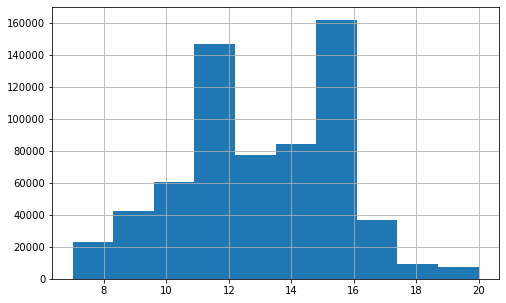

In [33]:
df.notna().sum(axis=1).hist(figsize=(8,5), bins=10)

In [34]:
df.notna().sum(axis=1).value_counts()

14    84147
16    81079
15    80786
13    77539
12    74197
11    72882
10    60670
9     42252
17    36637
8     18631
18     9407
19     5834
7      4615
20     1568
dtype: int64

In [35]:
df = df.dropna(thresh=10).reset_index()

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584746 entries, 0 to 584745
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   index                  584746 non-null  int64         
 1   belongs_to_collection  16130 non-null   object        
 2   budget_musd            30891 non-null   float64       
 3   genres                 430520 non-null  object        
 4   id                     584746 non-null  int64         
 5   original_language      584746 non-null  object        
 6   overview               502425 non-null  object        
 7   popularity             584746 non-null  float64       
 8   poster_path            423837 non-null  object        
 9   production_companies   278019 non-null  object        
 10  production_countries   382146 non-null  object        
 11  release_date           557774 non-null  datetime64[ns]
 12  revenue_musd           14696 non-null   floa

# Final Cleaning Steps

## All rows that contain movies that are not released will be dropped, since we are only interested in analyzing released movies.

In [37]:
df.status.value_counts()

Released           578044
In Production        2494
Planned              2159
Post Production      1849
Rumored               117
Canceled               83
Name: status, dtype: int64

In [38]:
df = df.loc[df.status == 'Released'].copy()

In [39]:
df

,index,belongs_to_collection,budget_musd,genres,id,original_language,overview,popularity,poster_path,production_companies,...,release_date,revenue_musd,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,year
0,0,Blondie Collection,NaN,Comedy,3924,en,Blondie and Dagwood are about to celebrate the...,2.445,/o6UMTE2LzQdlKVxRnFECPmtQjsJ.jpg,Columbia Pictures,...,1938-11-30,NaN,70.0,English,Released,NaN,Blondie,7.1,5,1938
1,1,NaN,NaN,Adventure,6124,de,Der Mann ohne Namen is a German adventure movi...,0.600,/6xUbUCvndklbGVYiljHr34NTxSl.jpg,NaN,...,1921-01-01,NaN,420.0,NaN,Released,NaN,"Peter Voss, Thief of Millions",NaN,0,1921
2,2,NaN,NaN,Drama|Romance,8773,fr,Love at Twenty unites five directors from five...,4.985,/aup2QCYCsyEeQfpboXy0f4uj8aE.jpg,Ulysse Productions|Unitec Films|Cinesecolo|Toh...,...,1962-06-22,NaN,110.0,Deutsch|Français|Italiano|日本語|Polski,Released,The Intimate Secrets of Young Lovers,Love at Twenty,6.8,36,1962
3,3,New World Disorder,NaN,NaN,25449,en,Gee Atherton ripping the Worlds course the day...,1.337,/okQY6jVmRU19CUbYPUZC77K3XBE.jpg,NaN,...,2008-12-08,NaN,69.0,English,Released,NaN,New World Disorder 9: Never Enough,4.5,2,2008
4,4,NaN,NaN,Family,31975,en,"Elmo is making a very, very super special surp...",0.600,/qKWcCmvGr4g0dgXvhqAc4BAMCtk.jpg,NaN,...,2010-01-05,NaN,46.0,NaN,Released,NaN,Sesame Street: Elmo Loves You!,NaN,0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584741,650250,NaN,NaN,Drama|Romance,890928,zh,NaN,0.600,/mLwFTBEOGONwSMRdLDl2H4Hgzfw.jpg,NaN,...,2018-04-30,NaN,NaN,普通话,Released,NaN,拯救内衣少爷,NaN,0,2018
584742,650251,NaN,NaN,Comedy,890929,zh,NaN,0.600,/tEycQp9r0x3DceuVHcxpo8u8FcT.jpg,NaN,...,2018-04-19,NaN,NaN,普通话,Released,NaN,妙探乌龙记,NaN,0,2018
584743,650252,NaN,NaN,Comedy|Fantasy,890930,ru,NaN,0.600,/zNgaE41owqpNacE4zY9alYBb1nT.jpg,Tsentralnoye televideniye,...,1979-03-11,NaN,NaN,Pусский,Released,NaN,Средство Макропулоса,NaN,0,1979
584744,650253,NaN,NaN,Family|Comedy|Romance,890931,te,A romantic Family entertainer,7.531,/bVtHOP1oCePnS5FX6XhJ67p0Djg.jpg,UV Concepts|Mass Media Production,...,2021-11-04,NaN,133.0,తెలుగు,Released,NaN,Manchi Rojulochaie,NaN,0,2021


In [40]:
df.drop('status', axis=1, inplace=True)

## Concatenating the poster_path column values into full URL format and creating a HTML image tag column

In [41]:
df.poster_path[0:4]

0    /o6UMTE2LzQdlKVxRnFECPmtQjsJ.jpg
1    /6xUbUCvndklbGVYiljHr34NTxSl.jpg
2    /aup2QCYCsyEeQfpboXy0f4uj8aE.jpg
3    /okQY6jVmRU19CUbYPUZC77K3XBE.jpg
Name: poster_path, dtype: object

In [42]:
def html_poster_path(value, return_html=False):
    if type(value) == str:
        if return_html == False:

            return f"https://image.tmdb.org/t/p/w500{value}"
        else:
            return f"<img src='https://image.tmdb.org/t/p/w500{value}' style='height:100px;'>"
    else:
        return np.nan

In [43]:
df['html'] = df['poster_path'].apply(lambda x: html_poster_path(x, True))
df['poster_path'] = df['poster_path'].apply(lambda x: html_poster_path(x))

In [44]:
df[['html', 'poster_path']].head()

,html,poster_path
0,<img src='https://image.tmdb.org/t/p/w500/o6UM...,https://image.tmdb.org/t/p/w500/o6UMTE2LzQdlKV...
1,<img src='https://image.tmdb.org/t/p/w500/6xUb...,https://image.tmdb.org/t/p/w500/6xUbUCvndklbGV...
2,<img src='https://image.tmdb.org/t/p/w500/aup2...,https://image.tmdb.org/t/p/w500/aup2QCYCsyEeQf...
3,<img src='https://image.tmdb.org/t/p/w500/okQY...,https://image.tmdb.org/t/p/w500/okQY6jVmRU19CU...
4,<img src='https://image.tmdb.org/t/p/w500/qKWc...,https://image.tmdb.org/t/p/w500/qKWcCmvGr4g0dg...


## Next, credits and cast information will be added to the DataFrame from the previously downloaded dataset.

In [3]:
credits = pd.read_csv('credits.csv')
credits

,0
0,"{'id': 3924, 'cast': [{'adult': False, 'gender..."
1,"{'id': 6124, 'cast': [{'adult': False, 'gender..."
2,"{'id': 8773, 'cast': [{'adult': False, 'gender..."
3,"{'id': 25449, 'cast': [{'adult': False, 'gende..."
4,"{'id': 31975, 'cast': [], 'crew': []}"
...,...
650241,"{'id': 890928, 'cast': [], 'crew': []}"
650242,"{'id': 890929, 'cast': [], 'crew': []}"
650243,"{'id': 890930, 'cast': [{'adult': False, 'gend..."
650244,"{'id': 890931, 'cast': [{'adult': False, 'gend..."


In [4]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650246 entries, 0 to 650245
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       650246 non-null  object
dtypes: object(1)
memory usage: 5.0+ MB


## Evaluating each value using literal_eval

In [46]:
credits['0'] = lit_eval(credits['0'])

In [47]:
credits = pd.json_normalize(credits['0'])
credits.head()

,id,cast,crew
0,3924,"[{'adult': False, 'gender': 1, 'id': 34178, 'k...","[{'adult': False, 'gender': 0, 'id': 34170, 'k..."
1,6124,"[{'adult': False, 'gender': 2, 'id': 48038, 'k...","[{'adult': False, 'gender': 2, 'id': 2902, 'kn..."
2,8773,"[{'adult': False, 'gender': 2, 'id': 1653, 'kn...","[{'adult': False, 'gender': 2, 'id': 1650, 'kn..."
3,25449,"[{'adult': False, 'gender': 0, 'id': 84130, 'k...","[{'adult': False, 'gender': 0, 'id': 112786, '..."
4,31975,[],[]


## Replacing empty list entries with NaN

In [30]:
for column in ['cast', 'crew']:
    credits[column] = credits[column].apply(lambda x: np.nan if len(x) == 0 else x)

In [31]:
credits.isnull().sum()

id           0
cast    217840
crew    116372
dtype: int64

## Dropping rows with less than 2 entries

In [32]:
credits.dropna(thresh=2, inplace=True)

## Extracting the names of both cast and crew columns for each row

In [33]:
credits['cast_names'] = credits['cast'].apply(lambda x: '|'.join([i['name'] for i in x]) if type(x) == list else np.nan)
credits['crew_names'] = credits['crew'].apply(lambda x: '|'.join([i['name'] for i in x]) if type(x) == list else np.nan)

## Getting cast and crew size for each movie.

In [34]:
credits['cast_size'] = credits.cast.apply(lambda x: len(x) if type(x) != float else np.nan)
credits['crew_size'] = credits.crew.apply(lambda x: len(x) if type(x) != float else np.nan)

### Extracting the director name for each movie

In [35]:
def get_director(x):
    if type(x) != float:
        for i in x:
            if i['job'] == 'Director':
                return i['name']
        return np.nan

In [36]:
credits['director'] = credits.crew.apply(get_director)

In [37]:
credits['director'].value_counts(dropna=False)

NaN                    46510
Dave Fleischer           494
D. W. Griffith           417
Kevin Dunn               373
Stan Brakhage            358
                       ...  
Cecily Fay                 1
Raaghav                    1
Yann Sông Le Van Ho        1
Kim Hyun-joon              1
Junca Avilés               1
Name: director, Length: 186778, dtype: int64

## Removing duplicate entries

In [38]:
credits.drop_duplicates(subset='id', inplace=True)

## Joining Both DataFrames

In [81]:
combined_df = df.merge(credits[['id', 'cast_names', 'crew_names', 'director']], on='id', how='left')

In [82]:
combined_df.head()

,index,belongs_to_collection,budget_musd,genres,id,original_language,overview,popularity,poster_path,production_companies,...,spoken_languages,tagline,title,vote_average,vote_count,year,html,cast_names,crew_names,director
0,0,Blondie Collection,NaN,Comedy,3924,en,Blondie and Dagwood are about to celebrate the...,2.445,https://image.tmdb.org/t/p/w500/o6UMTE2LzQdlKV...,Columbia Pictures,...,English,NaN,Blondie,7.1,5,1938,<img src='https://image.tmdb.org/t/p/w500/o6UM...,Penny Singleton|Arthur Lake|Larry Simms|Daisy|...,Frank R. Strayer|Richard Flournoy,Frank R. Strayer
1,1,NaN,NaN,Adventure,6124,de,Der Mann ohne Namen is a German adventure movi...,0.600,https://image.tmdb.org/t/p/w500/6xUbUCvndklbGV...,NaN,...,NaN,NaN,"Peter Voss, Thief of Millions",NaN,0,1921,<img src='https://image.tmdb.org/t/p/w500/6xUb...,Harry Liedtke|Georg Alexander|Mady Christians|...,Robert Liebmann|Frederik Fuglsang|Georg Jacoby...,Georg Jacoby
2,2,NaN,NaN,Drama|Romance,8773,fr,Love at Twenty unites five directors from five...,4.985,https://image.tmdb.org/t/p/w500/aup2QCYCsyEeQf...,Ulysse Productions|Unitec Films|Cinesecolo|Toh...,...,Deutsch|Français|Italiano|日本語|Polski,The Intimate Secrets of Young Lovers,Love at Twenty,6.8,36,1962,<img src='https://image.tmdb.org/t/p/w500/aup2...,Jean-Pierre Léaud|Marie-France Pisier|Patrick ...,François Truffaut|François Truffaut|Gérard Bra...,François Truffaut
3,3,New World Disorder,NaN,NaN,25449,en,Gee Atherton ripping the Worlds course the day...,1.337,https://image.tmdb.org/t/p/w500/okQY6jVmRU19CU...,NaN,...,English,NaN,New World Disorder 9: Never Enough,4.5,2,2008,<img src='https://image.tmdb.org/t/p/w500/okQY...,Darren Berrecloth|Cameron McCaul|Paul Basagoit...,Derek Westerlund,Derek Westerlund
4,4,NaN,NaN,Family,31975,en,"Elmo is making a very, very super special surp...",0.600,https://image.tmdb.org/t/p/w500/qKWcCmvGr4g0dg...,NaN,...,NaN,NaN,Sesame Street: Elmo Loves You!,NaN,0,2010,<img src='https://image.tmdb.org/t/p/w500/qKWc...,NaN,NaN,NaN


## Saving the final DataFrame into a csv file.

In [83]:
combined_df.to_csv('movies_complete.csv', index = False)

### In Part 2 of this project, we will try and gain some insight from the cleaned data about what types of movies are more popular, the average budget and revenue of the most successful movies, what genres are more popular, and many more.